In [30]:
import torch
import torch.nn as  nn
import torch.nn.functional as F

In [54]:
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_, out_, i_downsample=None, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(in_, out_, kernel_size=1, stride=1, padding=0)
        self.norm1 = nn.BatchNorm2d(out_)

        self.conv2 = nn.Conv2d(out_, out_, kernel_size=3, stride=stride, padding=1)
        self.norm2 = nn.BatchNorm2d(out_)

        self.conv3 = nn.Conv2d(out_, out_*self.expansion, kernel_size=1, stride=1, padding=0)
        self.norm3 = nn.BatchNorm2d(out_*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x.clone()

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)

        # downsample if needed
        if self.i_downsample is not None:
            residual = self.i_downsample(residual)

        # add residual
        x += residual
        x = self.relu(x)
        return x

In [55]:
class Block(nn.Module):
    expansion = 1
    def __init__(self, in_, out_, i_downsample=None, stride=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_, out_, kernel_size=3, padding=1, stride=stride, bias=False)
        self.norm1 = nn.BatchNorm2d(out_)

        self.conv2 = nn.Conv2d(out_, out_, kernel_size=3, padding=1, stride=stride, bias=False)
        self.norm2 = nn.BatchNorm2d(out_)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      residual = x.clone()

      x = self.conv1(x)
      x = self.norm1(x)
      x = self.relu(x)

      x = self.conv2(x)
      x = self.norm2(x)

      if self.i_downsample is not None:
          residual = self.i_downsample(residual)

      x += residual
      x = self.relu(x)
      return x

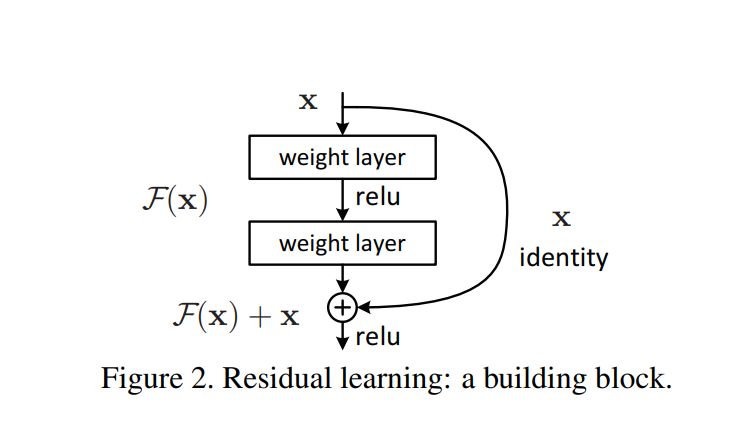

In [40]:
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)



def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)


In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [36]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [37]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [38]:
classes = ['plane', 'car',
           'bird', 'cat',
           'deer', 'dog',
           'frog', 'horse',
           'ship', 'truck']

In [41]:
net = ResNet50(10).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [42]:
EPOCHS = 200
for epoch in range(EPOCHS):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%100 == 0 and i > 0:
            print(f'Loss [{epoch+1}, {i}](epoch, minibatch): ', running_loss / 100)
            running_loss = 0.0

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

print('Training Done')

Loss [1, 100](epoch, minibatch):  8.666070549488067
Loss [1, 200](epoch, minibatch):  2.7789292454719545
Loss [1, 300](epoch, minibatch):  2.23908882021904
Loss [2, 100](epoch, minibatch):  2.0562817811965943
Loss [2, 200](epoch, minibatch):  1.9847317159175872
Loss [2, 300](epoch, minibatch):  1.9680142533779144
Loss [3, 100](epoch, minibatch):  1.9348725378513336
Loss [3, 200](epoch, minibatch):  1.872238209247589
Loss [3, 300](epoch, minibatch):  1.8324473309516907
Loss [4, 100](epoch, minibatch):  1.8076594877243042
Loss [4, 200](epoch, minibatch):  1.7725582587718964
Loss [4, 300](epoch, minibatch):  1.7424206042289734
Loss [5, 100](epoch, minibatch):  1.7328384447097778
Loss [5, 200](epoch, minibatch):  1.6865248000621795
Loss [5, 300](epoch, minibatch):  1.6738202500343322
Loss [6, 100](epoch, minibatch):  1.652974624633789
Loss [6, 200](epoch, minibatch):  1.6191646003723144
Loss [6, 300](epoch, minibatch):  1.5791835272312165
Loss [7, 100](epoch, minibatch):  1.581926956176757

KeyboardInterrupt: 

In [43]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy on 10,000 test images: ', 100*(correct/total), '%')

Accuracy on 10,000 test images:  75.29 %


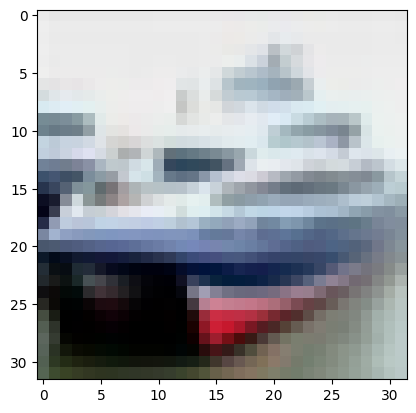

Class label: ship
Predicted class label: ship


In [50]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert from Tensor image format
    plt.show()

# Get one batch of images
images, labels = next(iter(testloader))

classes = test.classes

# Show one image and its class
index = 1  # Index of the image you want to display
imshow(images[index])


net.eval()
image = images[index].unsqueeze(0).to('cuda')
with torch.no_grad():
    outputs = net(image)
    _, predicted = torch.max(outputs.data, 1)
# Print the class label
print(f'Class label: {classes[labels[index]]}')
print(f'Predicted class label: {classes[predicted.item()]}')

In [51]:
torch.save(net.state_dict(), 'ResNet.pth')

In [53]:
net = ResNet50(10).to('cuda')
net.load_state_dict(torch.load('ResNet.pth'))
net.eval()

<ipython-input-53-f84b3c653196>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('ResNet.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m